In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Muons

## Muon generation

In [2]:
from tomopt.muon import generate_batch

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from tomopt.muon import MuonBatch

In [5]:
import torch
from torch import Tensor

In [11]:
torch.randn(int(1e8)).pow(2).mean()

tensor(1.0002)

In [6]:
from tomopt.core import X0

In [7]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*1e5
    if z >= 0.5 and z <= 0.5: rad_length[...] = X0['lead']#X0['beryllium']
#     if z == 0.6 : rad_length[...] = X0['beryllium']
        
    return rad_length

In [8]:
from tomopt.volume import PassiveLayer, DetectorLayer

### Cost functions

In [9]:
import torch.nn.functional as F

In [10]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [11]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [94]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 10000000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [95]:
import numpy as np
from torch import nn

In [96]:
from tomopt.volume import Volume

In [97]:
batch = MuonBatch(generate_batch(1000), init_z=1)

In [98]:
start = batch.copy()

In [99]:
volume = Volume(get_layers())

In [100]:
volume(batch)

# Atomic number reco

## Compute deviations and scatter locations

In [101]:
from tomopt.inference import ScatterBatch

In [102]:
scatters = ScatterBatch(batch, volume)

In [103]:
mask = scatters.get_scatter_mask()

scatters.theta_in[mask].pow(2).sum(1).sqrt()

scatters.theta_out[mask].pow(2).sum(1).sqrt()

In [104]:
scatters.dtheta[mask].pow(2).sum(1).sqrt()

tensor([1.3421e-05, 1.5458e-05, 1.2072e-05, 5.8341e-06, 1.6099e-05, 1.3791e-05,
        8.6666e-06, 4.2089e-06, 1.1135e-05, 1.0962e-05, 2.9132e-06, 2.7043e-06,
        7.5048e-06, 5.1853e-06, 1.1681e-05, 2.6247e-06, 7.5374e-06, 7.3478e-06,
        4.0212e-06, 1.5183e-05, 9.9945e-06, 1.3261e-06, 1.4578e-05, 2.3238e-06,
        1.0559e-05, 1.3444e-05, 7.1589e-06, 4.5850e-06, 1.0489e-05, 1.0119e-05,
        5.9932e-06, 3.0335e-06, 1.4262e-05, 1.5838e-05, 1.0856e-05, 6.7215e-06,
        2.4576e-06, 4.6748e-06, 9.3863e-06, 8.5099e-06, 7.6628e-06, 1.8447e-05,
        1.1970e-05, 1.2582e-05, 3.1538e-06, 4.9426e-06, 9.0763e-06, 2.5809e-05,
        7.9417e-06, 1.0671e-05, 5.8156e-06, 8.7415e-06, 6.8834e-06, 7.9836e-06,
        1.5076e-05, 3.3283e-06, 8.5538e-06, 4.1050e-06, 6.3052e-06, 1.4875e-05,
        1.1479e-05, 1.1020e-05, 7.0594e-06, 8.7297e-06, 6.0610e-06, 1.3823e-05,
        1.2848e-05, 4.7944e-06, 8.5905e-06, 6.6389e-06, 1.0691e-05, 9.0655e-06,
        4.6872e-06, 1.4987e-05, 8.7310e-

In [105]:
mask2 = (batch.get_xy_mask(volume.lw))

In [106]:
scatters.theta_in_unc

tensor([[1.9635e-07, 1.7524e-06],
        [8.2794e-07, 7.5740e-07],
        [1.6915e-06, 1.2112e-06],
        ...,
        [1.3843e-06, 2.9444e-07],
        [2.0327e-06, 5.9696e-07],
        [1.3433e-06, 6.3192e-07]], grad_fn=<SqrtBackward>)

## Infer rad length

In [107]:
from tomopt.inference import X0Inferer

In [108]:
x0_inferer = X0Inferer(scatters)

pred_debias, weight = x0_inferer.x0_from_dtheta()

In [127]:
pred_bias, unc = x0_inferer.x0_from_dtheta()

In [134]:
(pred_bias/unc).max()

tensor(10.7495, grad_fn=<MaxBackward1>)

In [128]:
unc

tensor([2.4765e+03, 1.4225e+03, 4.0950e+03, 1.7887e+04, 1.1353e+03, 1.7498e+03,
        7.8279e+03, 1.0386e+05, 2.8364e+03, 2.7813e+03, 1.8627e+05, 1.5194e+05,
        9.8018e+03, 4.6825e+04, 3.4415e+03, 2.9811e+05, 1.0277e+04, 2.1643e+04,
        7.7985e+04, 1.0321e+03, 3.3791e+03, 1.9260e+06, 1.1208e+03, 4.4674e+05,
        3.3558e+03, 2.1268e+03, 1.4203e+04, 3.5983e+04, 5.1113e+03, 3.8899e+03,
        3.4650e+04, 2.1483e+05, 1.6336e+03, 1.5646e+03, 4.7147e+03, 2.5540e+04,
        2.0938e+05, 5.4857e+04, 6.8923e+03, 6.9193e+03, 1.1933e+04, 1.0776e+03,
        2.1182e+03, 2.3113e+03, 1.6140e+05, 3.5561e+04, 5.2288e+03, 2.3235e+02,
        6.1941e+03, 4.0155e+03, 2.2903e+04, 9.5209e+03, 1.3863e+04, 1.4916e+04,
        1.7194e+03, 9.6436e+04, 1.2360e+04, 7.4290e+04, 1.7256e+04, 2.2505e+03,
        1.2582e+03, 3.7204e+03, 2.6225e+04, 5.5376e+03, 5.0385e+04, 2.2591e+03,
        1.7101e+03, 5.5938e+04, 7.1629e+03, 2.0330e+04, 5.6893e+03, 9.2197e+03,
        2.6721e+04, 2.2961e+03, 9.1115e+

In [124]:
pred,w = x0_inferer.pred_x0()

pred_debias.mean()

In [110]:
dtheta, dtheta_unc = scatters.dtheta.detach().numpy(), scatters.dtheta_unc.detach().numpy()

In [111]:
volume.get_detectors()[-1].resolution.mean()

tensor(10000000., grad_fn=<MeanBackward0>)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

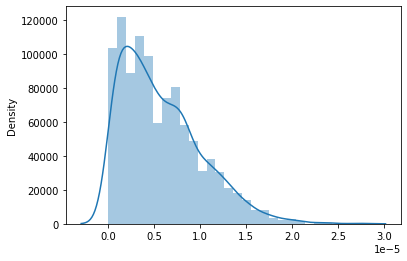

In [112]:
sns.distplot(dtheta)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

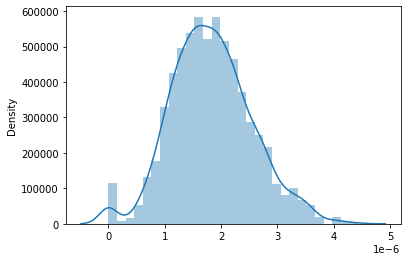

In [113]:
sns.distplot(dtheta_unc)

<ipython-input-114-114150e114fc>:1: RuntimeWarning: invalid value encountered in true_divide
  sns.distplot(dtheta_unc/dtheta, bins=1000); plt.xlim([0,10])
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 10.0)

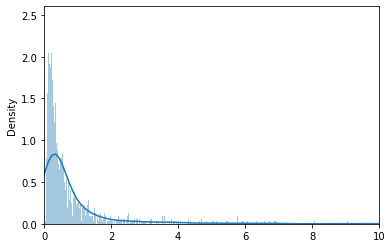

In [114]:
sns.distplot(dtheta_unc/dtheta, bins=1000); plt.xlim([0,10])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

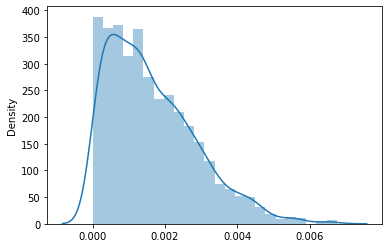

In [64]:
sns.distplot(dtheta)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

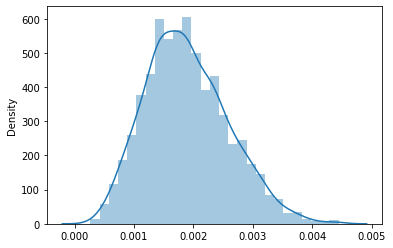

In [65]:
sns.distplot(dtheta_unc)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 10.0)

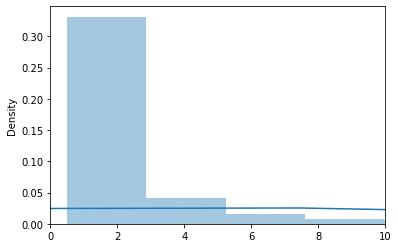

In [72]:
sns.distplot(dtheta_unc/dtheta, bins=1000); plt.xlim([0,10])

In [62]:
pred_bias.mean()

tensor(0.4264, grad_fn=<MeanBackward0>)

In [45]:
pred_bias.mean()

tensor(0.0089, grad_fn=<MeanBackward0>)

In [28]:
pred_bias.mean()

tensor(4215.3760, grad_fn=<MeanBackward0>)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.2)

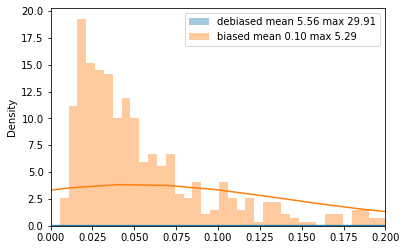

In [131]:
p = pred_debias.detach().numpy()
pb = pred_bias.detach().numpy()

sns.distplot(p, label=f'debiased mean {p.mean():.2f} max {p.max():.2f}', bins=1000)
sns.distplot(pb, label=f'biased mean {pb.mean():.2f} max {pb.max():.2f}', bins=1000)
plt.legend()
plt.xlim([0,0.2])

In [69]:
pred.mean()

tensor(0.1037, grad_fn=<MeanBackward0>)

(0.0, 0.2)

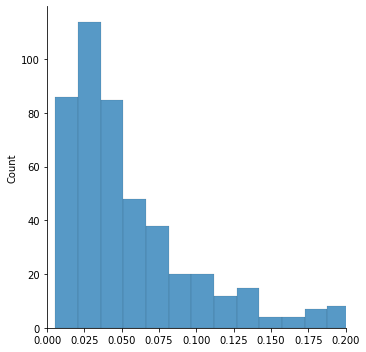

In [75]:
p = pred.detach().numpy()
sns.displot(p)
plt.xlim([0,0.2])

In [32]:
X0['lead'],X0['beryllium']

(0.005612, 0.3528)

In [119]:
pred,weight = x0_inferer.pred_x0()

# Inversion test

In [211]:
from tomopt.core import X0, SCATTER_COEF_A

In [213]:
import math

In [270]:
X0['beryllium']

0.3528

In [267]:
deltaz = 0.1
theta_in = Tensor([math.pi/4])
x0 = deltaz / (X0['beryllium']*torch.cos(theta_in))
z1 = 1#torch.randn(n, device=self.device)
z2 = 1#torch.randn(n, device=self.device)

print(x0)
theta0 = (SCATTER_COEF_A / 100) * torch.sqrt(x0)  # Ignore due to inversion problems * (1+(SCATTER_COEF_B*torch.log(x0)))
print(theta0)
theta_msc = math.sqrt(2) * z2 * theta0
print(theta_msc)
phi_msc = Tensor([2 * math.pi])

dtheta_x = theta_msc * torch.cos(phi_msc)
dtheta_y = theta_msc * torch.sin(phi_msc)
dtheta = torch.sqrt(dtheta_x.pow(2)+dtheta_y.pow(2))
theta_out = theta_in+dtheta

tensor([0.4009])
tensor([8.6106e-05])
tensor([0.0001])


In [268]:
dtheta

tensor([0.0001])

In [269]:
theta2 = dtheta.pow(2)
theta02 = theta2/2
print(theta02.sqrt())
n_x0 = theta02 * ((100 / SCATTER_COEF_A) ** 2)
print(n_x0)
cos_theta_in = torch.cos(theta_in)
deltaz/(n_x0 * cos_theta_in)

tensor([8.6106e-05])
tensor([0.4009])


tensor([0.3528])